In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import copy
import yaml
from datetime import datetime, timezone
from typing import Tuple, Dict

from simulator_external.simulator.simulator import *
from simulator_external.simulator.load_data import load_md_from_file
from stoikov.stoikov import StoikovStrategy
from stoikov_predictor import StoikovPredictorStrategy, BasePredictor, PredictorIdeal, PredictorNoisy
from simulator_external.simulator.get_info import get_metrics, md_to_dataframe

In [4]:
MARKET_DATA_PATH = '../../data/1/btcusdt:Binance:LinearPerpetual/'

In [5]:
def my_round(x, ndigits):
    return round(float(x), ndigits)

def get_metrics_numeric(metrics):
    metrics_numeric = {
        'Final PnL':    my_round(metrics['worth_quote'].iloc[-1], 2),
        'Final volume': my_round(metrics['volume'].iloc[-1], 3),
        'Base balance': {
            'min':    my_round(metrics['base_balance'].min(), 3),
            'max':    my_round(metrics['base_balance'].max(), 3),
            'median': my_round(metrics['base_balance'].median(), 3),
        },
        'Quote balance': {
            'min':    my_round(metrics['quote_balance'].min(), 2),
            'max':    my_round(metrics['quote_balance'].max(), 2),
            'median': my_round(metrics['quote_balance'].median(), 2),
        }
    }
    return metrics_numeric

def backtest(md, predictor: BasePredictor,
             sim_params: dict, strat_params: dict, fee: float) -> Tuple[pd.DataFrame, Dict]:
    """Run backtest and return results.
    Args:
        md: Parameter `md` (market data) for `Sim` constructor.
        predictor: Parameter `predictor` for `StoikovPredictorStrategy` constructor.
        sim_params: All parameters for `Sim` constructor, except `md`
        strat_params: All parameters for StoikovStrategy constructor, except `sim`.
        fee: Parameter `fee` for `get_metrics()` function.
    Returns:
        Simulation metrics in form of time series and single quantities.
    """
    sim = Sim(md, **sim_params)
    strategy = StoikovPredictorStrategy(sim=sim, predictor=predictor, **strat_params)
    trades_list, md_list, updates_list, all_orders = strategy.run()
    metrics = get_metrics(updates_list, fee=fee)
    metrics_numeric = get_metrics_numeric(metrics)
    return metrics, metrics_numeric

In [6]:
def anno_metrics_numeric(fig: go.Figure, metrics_numeric: Dict) -> go.Figure:
    metrics_numeric_txt = yaml.dump(
        metrics_numeric, default_flow_style=False, sort_keys=False
    ).replace('\n', '<br>')
    fig.add_annotation(text=metrics_numeric_txt,
                       xref='paper', yref='paper', x=1.12, y=0.9,
                       align='left', font={'family': 'monospace'},
                       bordercolor='black')
    fig.update_layout(margin={'r': 185})
    return fig


def anno_params(fig: go.Figure, sim_params: Dict, strat_params: Dict, fee: float) -> go.Figure:
    sim_params_copy = copy.deepcopy(sim_params)
    sim_params_copy['execution_latency'] = '{:,}'.format(sim_params['execution_latency'])
    sim_params_copy['md_latency'] = '{:,}'.format(sim_params['md_latency'])
    strat_params_copy = copy.deepcopy(strat_params)
    strat_params_copy['adjust_delay'] = '{:,}'.format(strat_params['adjust_delay'])
    params_txt = yaml.dump({'Simulator parameters': sim_params_copy},
                           default_flow_style=False, sort_keys=False) + '\n' + \
                 yaml.dump({'Strategy parameters': strat_params_copy},
                           default_flow_style=False, sort_keys=False) + '\n' + \
                 yaml.dump({'Maker/taker fee': f'{fee*100}%'},
                           default_flow_style=False, sort_keys=False)
    params_txt = params_txt.replace('\n', '<br>')

    fig.add_annotation(text=params_txt,
                       xref='paper', yref='paper', x=1.154, y=0.715,
                       align='left', font={'family': 'monospace'},
                       bordercolor='black')
    fig.update_layout(margin={'r': 250})
    return fig


def plot_metrics(metrics, title='') -> go.Figure:
    """Visualize backtesting results"""
    fig = make_subplots(rows=5, cols=1, row_heights=[0.3, 0.3, 0.2, 0.2, 0.2],
                        shared_xaxes=True, vertical_spacing=0.005)
    fig.add_trace(go.Scatter(
        name='PnL',
        x=metrics['receive_ts'],
        y=metrics['worth_quote'],
        line=dict(color=px.colors.qualitative.Plotly[0]),
        showlegend=False
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        name='Mid-price',
        x=metrics['receive_ts'],
        y=metrics['mid_price'],
        line=dict(color=px.colors.qualitative.Plotly[5]),
        showlegend=False
    ), row=2, col=1)

    fig.add_trace(go.Scatter(
        name='Volume',
        x=metrics['receive_ts'],
        y=metrics['volume'],
        line=dict(color=px.colors.qualitative.Plotly[2]),
        showlegend=False
    ), row=3, col=1)

    fig.add_trace(go.Scatter(
        name='Base balance',
        x=metrics['receive_ts'],
        y=metrics['base_balance'],
        line=dict(color=px.colors.qualitative.Plotly[3]),
        showlegend=False
    ), row=4, col=1)

    fig.add_trace(go.Scatter(
        name='Quote balance',
        x=metrics['receive_ts'],
        y=metrics['quote_balance'],
        line=dict(color=px.colors.qualitative.Plotly[4]),
        showlegend=False
    ), row=5, col=1)

    fig.update_layout(width=1200, height=1400,
                      title=title, xaxis5_title='Receive time',
                      yaxis1_title='PnL (account worth in quote asset)', yaxis2_title='Mid-price',
                      yaxis3_title='Trade volume', yaxis4_title='Base asset balance',
                      yaxis5_title='Quote asset balance')
    fig.update_traces(xaxis='x5')
    fig.update_xaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    fig.update_yaxes(showspikes=True, spikemode='across', spikedash='dot', spikethickness=2)
    return fig

In [7]:
MIN_TS = pd.Timestamp('2022-06-23 15:35:00')
MAX_TS = pd.Timestamp('2022-06-23 19:00:00')

In [8]:
md = load_md_from_file(MARKET_DATA_PATH, MIN_TS, MAX_TS)

In [9]:
sim_params = {
    'execution_latency': 10_000_000,
    'md_latency': 10_000_000
}
strat_params = {
    'gamma': 2,
    'k': 0.8,  # calculated from BTCUSDT market data (see eda/eda-btc.ipynb)
    'sigma': 1,
    'terminal_time': False,
    'adjust_delay': 1_000_000,
    'order_size': 0.001,
    'min_order_size': 0.001,
    'precision': 2
}
FEE = 0.0

In [10]:
md_df = md_to_dataframe(md)
midprices = md_df[['receive_ts', 'mid_price']].set_index('receive_ts')

# Original Stoikov strategy

In [ ]:
sim = Sim(md, **sim_params)
strategy = StoikovStrategy(sim, **strat_params)
_, _, updates_list, _ = strategy.run()
launch_time = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

In [12]:
metrics = get_metrics(updates_list, fee=FEE)
metrics_numeric = get_metrics_numeric(metrics)

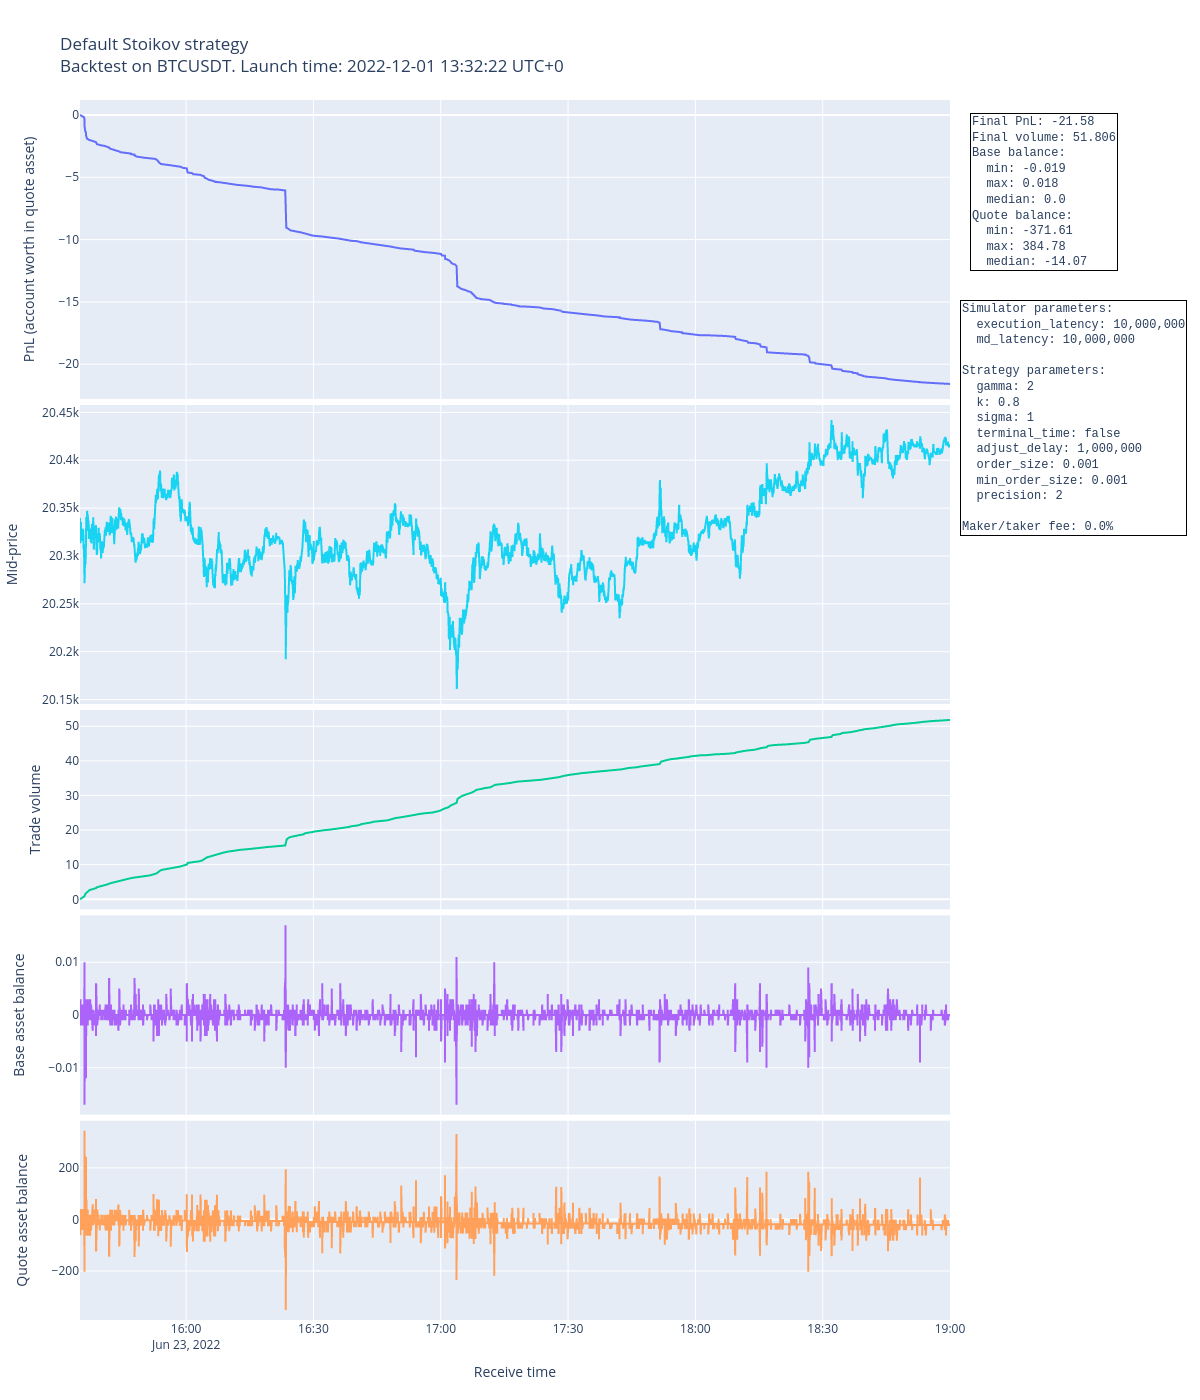

In [13]:
fig = plot_metrics(metrics[::60],
                   title=f'Default Stoikov strategy<br>'
                         f'Backtest on BTCUSDT. Launch time: {launch_time}')
anno_metrics_numeric(fig, metrics_numeric)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/00_stoikov_default.png')

# Stoikov spread around price predictor

This is a modification of Stoikov strategy (`stoikov_test.ipynb`), where instead of indifference price, orders are placed around predicted price at some moment in the future.

# Ideal predictor, 1 second time horizon


In [14]:
predictor_ideal = PredictorIdeal(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                 time_offset=pd.Timedelta(1_000_000_000))

In [ ]:
metrics_ideal, metrics_num_ideal = backtest(md, predictor_ideal, sim_params, strat_params, FEE)
launch_time_ideal = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

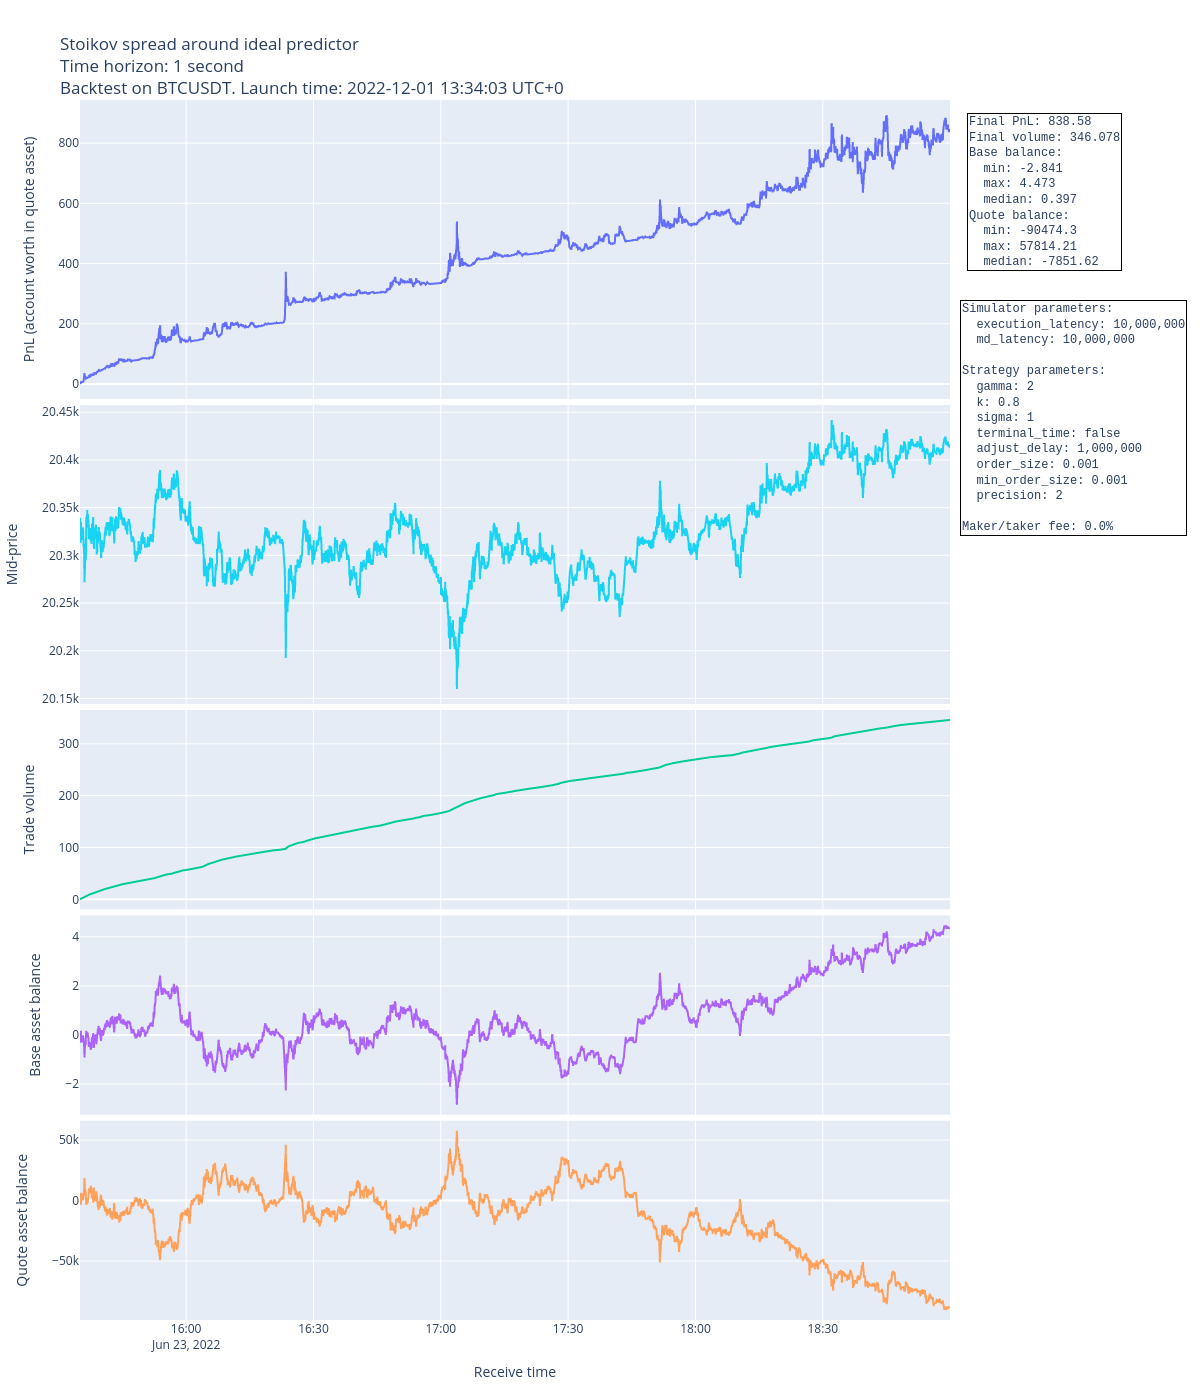

In [16]:
fig = plot_metrics(metrics_ideal[::60],
                   title=f'Stoikov spread around ideal predictor<br>'
                         f'Time horizon: 1 second'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_ideal}')
anno_metrics_numeric(fig, metrics_num_ideal)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/01_1_sec_ideal.png')

# Noisy predictors, 1 second time horizon

Here I add uniformly distributed noise to the ideal prediction, simulating fixed-range error.

## Prediction error: $\pm 0.2\%$

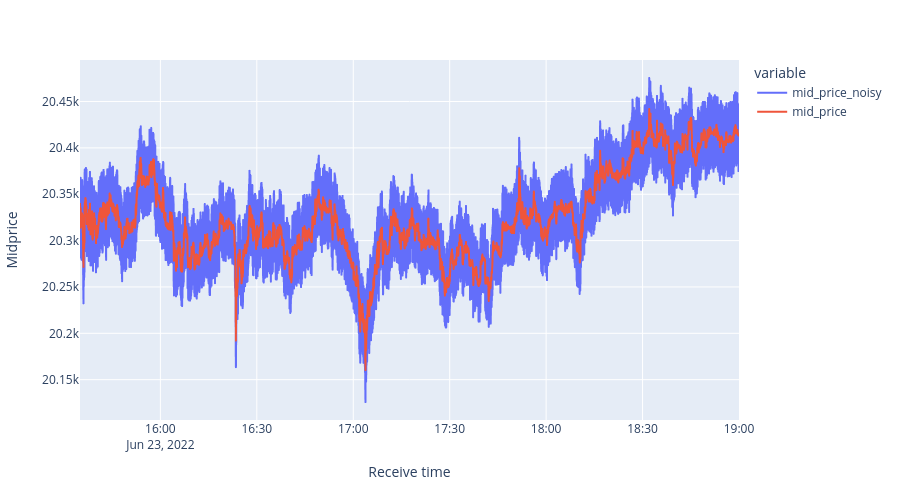

In [17]:
md_df['mid_price_noisy'] = md_df['mid_price']*np.random.uniform(0.998, 1.002, size=len(md_df))
fig = px.line(md_df[::60], x='receive_ts', y=md_df.columns[[-1, -2]])
fig.update_layout(xaxis_title='Receive time', yaxis_title='Midprice', width=900)
fig.show(renderer='png')

In [18]:
predictor_noisy1 = PredictorNoisy(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                  time_offset=pd.Timedelta(1_000_000_000),
                                  noise_func=lambda: np.random.uniform(0.998, 1.002))

In [ ]:
metrics_noisy1, metrics_num_noisy1 = backtest(md, predictor_noisy1, sim_params, strat_params, FEE)
launch_time_noisy1 = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

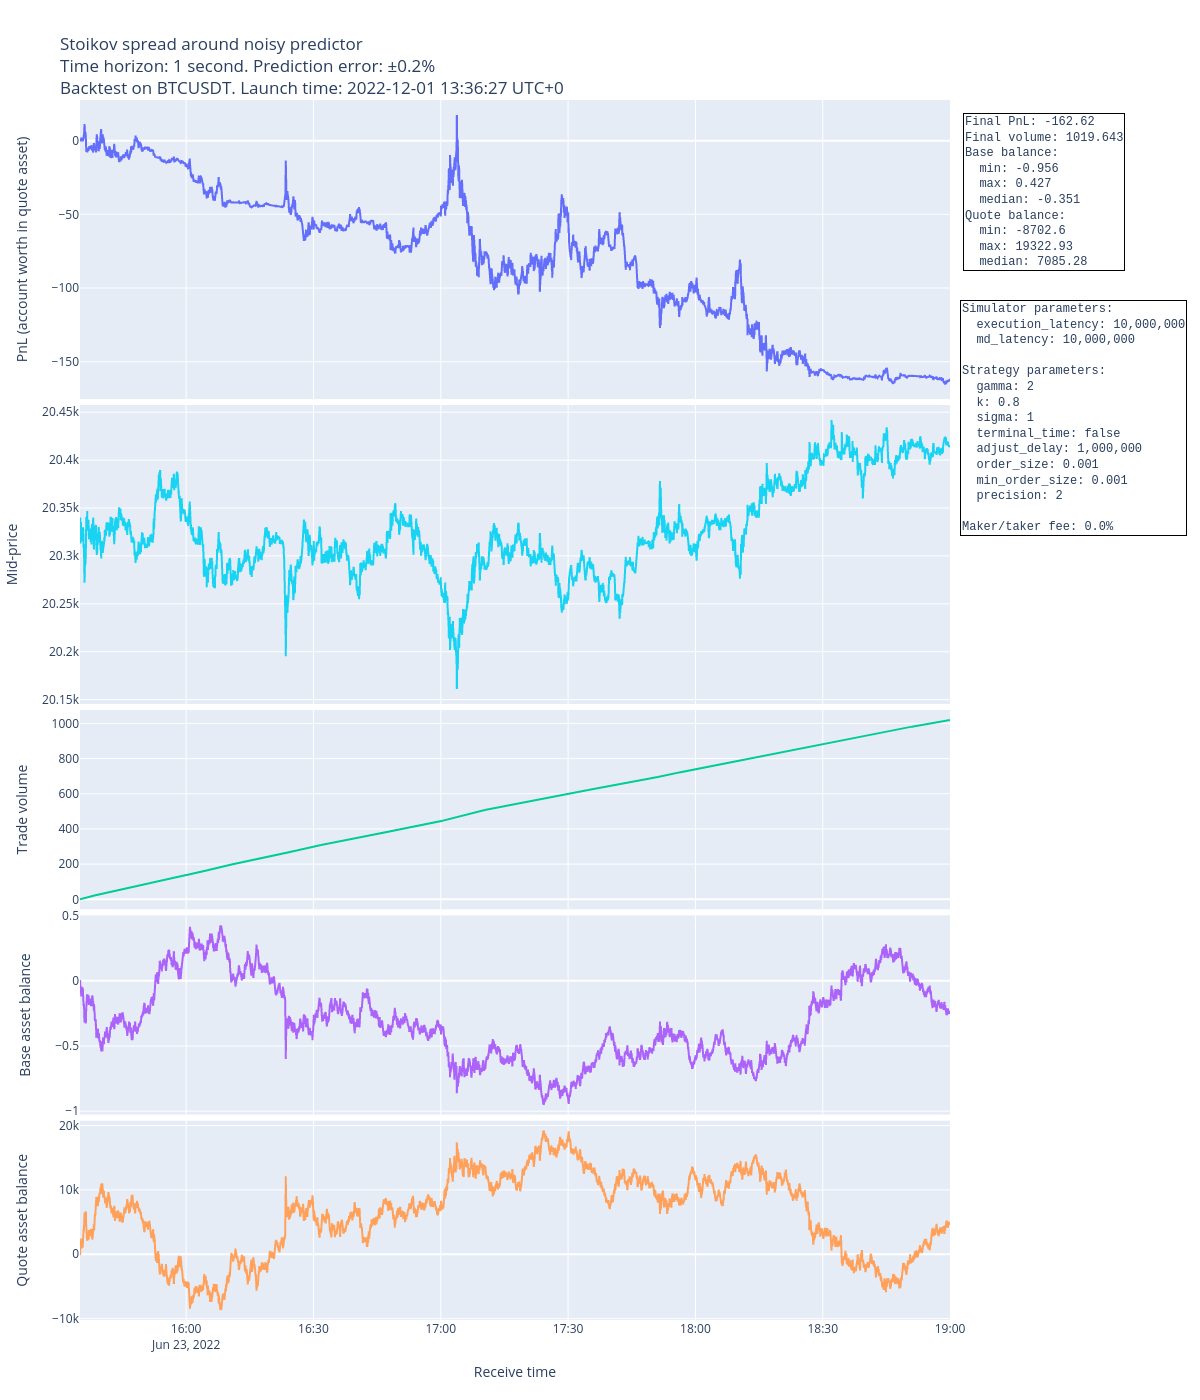

In [20]:
fig = plot_metrics(metrics_noisy1[::60],
                   title=f'Stoikov spread around noisy predictor<br>'
                         f'Time horizon: 1 second. Prediction error: ±0.2%'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_noisy1}')
anno_metrics_numeric(fig, metrics_num_noisy1)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/02_1_sec_err_0.2%.png')

## Prediction error: $\pm 0.5\%$

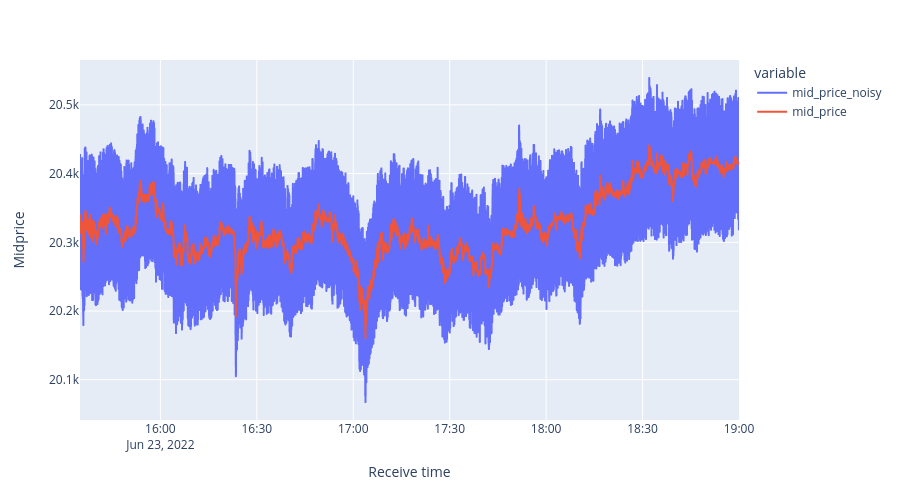

In [21]:
md_df['mid_price_noisy'] = md_df['mid_price']*np.random.uniform(0.995, 1.005, size=len(md_df))
fig = px.line(md_df[::60], x='receive_ts', y=md_df.columns[[-1, -2]])
fig.update_layout(xaxis_title='Receive time', yaxis_title='Midprice', width=900)
fig.show(renderer='png')

In [22]:
predictor_noisy2 = PredictorNoisy(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                  time_offset=pd.Timedelta(1_000_000_000),
                                  noise_func=lambda: np.random.uniform(0.995, 1.005))

In [ ]:
metrics_noisy2, metrics_num_noisy2 = backtest(md, predictor_noisy2, sim_params, strat_params, FEE)
launch_time_noisy2 = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

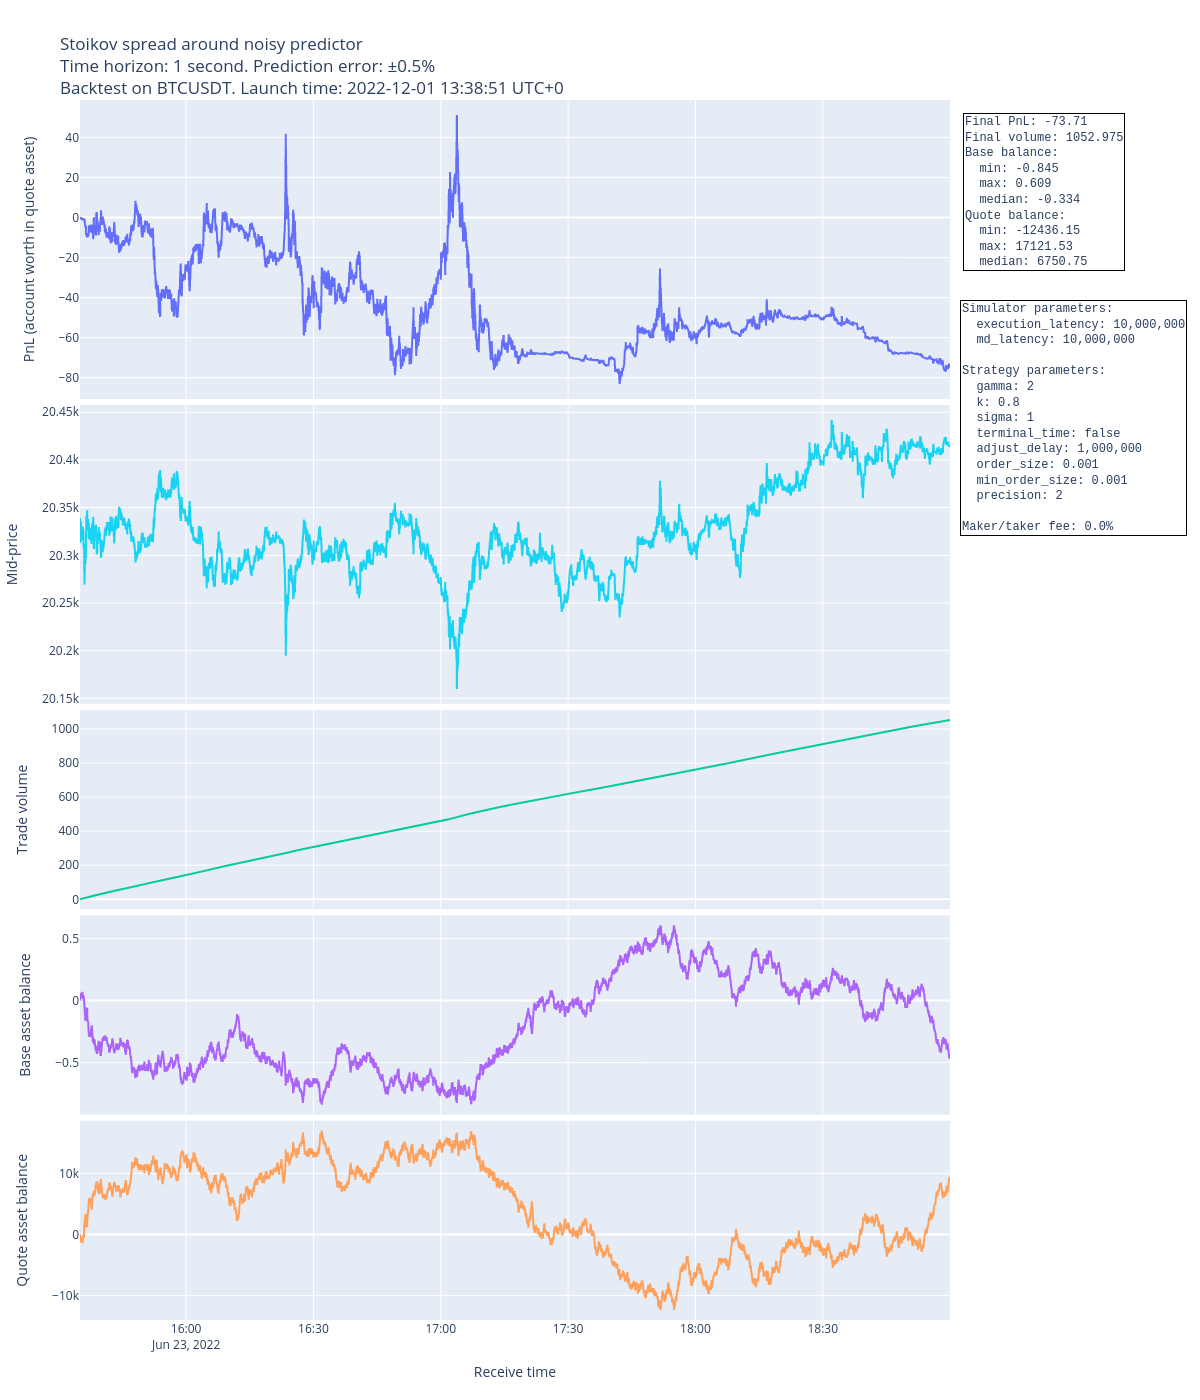

In [24]:
fig = plot_metrics(metrics_noisy2[::60],
                   title=f'Stoikov spread around noisy predictor<br>'
                         f'Time horizon: 1 second. Prediction error: ±0.5%'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_noisy2}')
anno_metrics_numeric(fig, metrics_num_noisy2)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/03_1_sec_err_0.5%.png')

# Ideal predictor, 200 ms time horizon


In [25]:
predictor_ideal = PredictorIdeal(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                 time_offset=pd.Timedelta(200_000_000))

In [ ]:
metrics_ideal, metrics_num_ideal = backtest(md, predictor_ideal, sim_params, strat_params, FEE)
launch_time_ideal = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

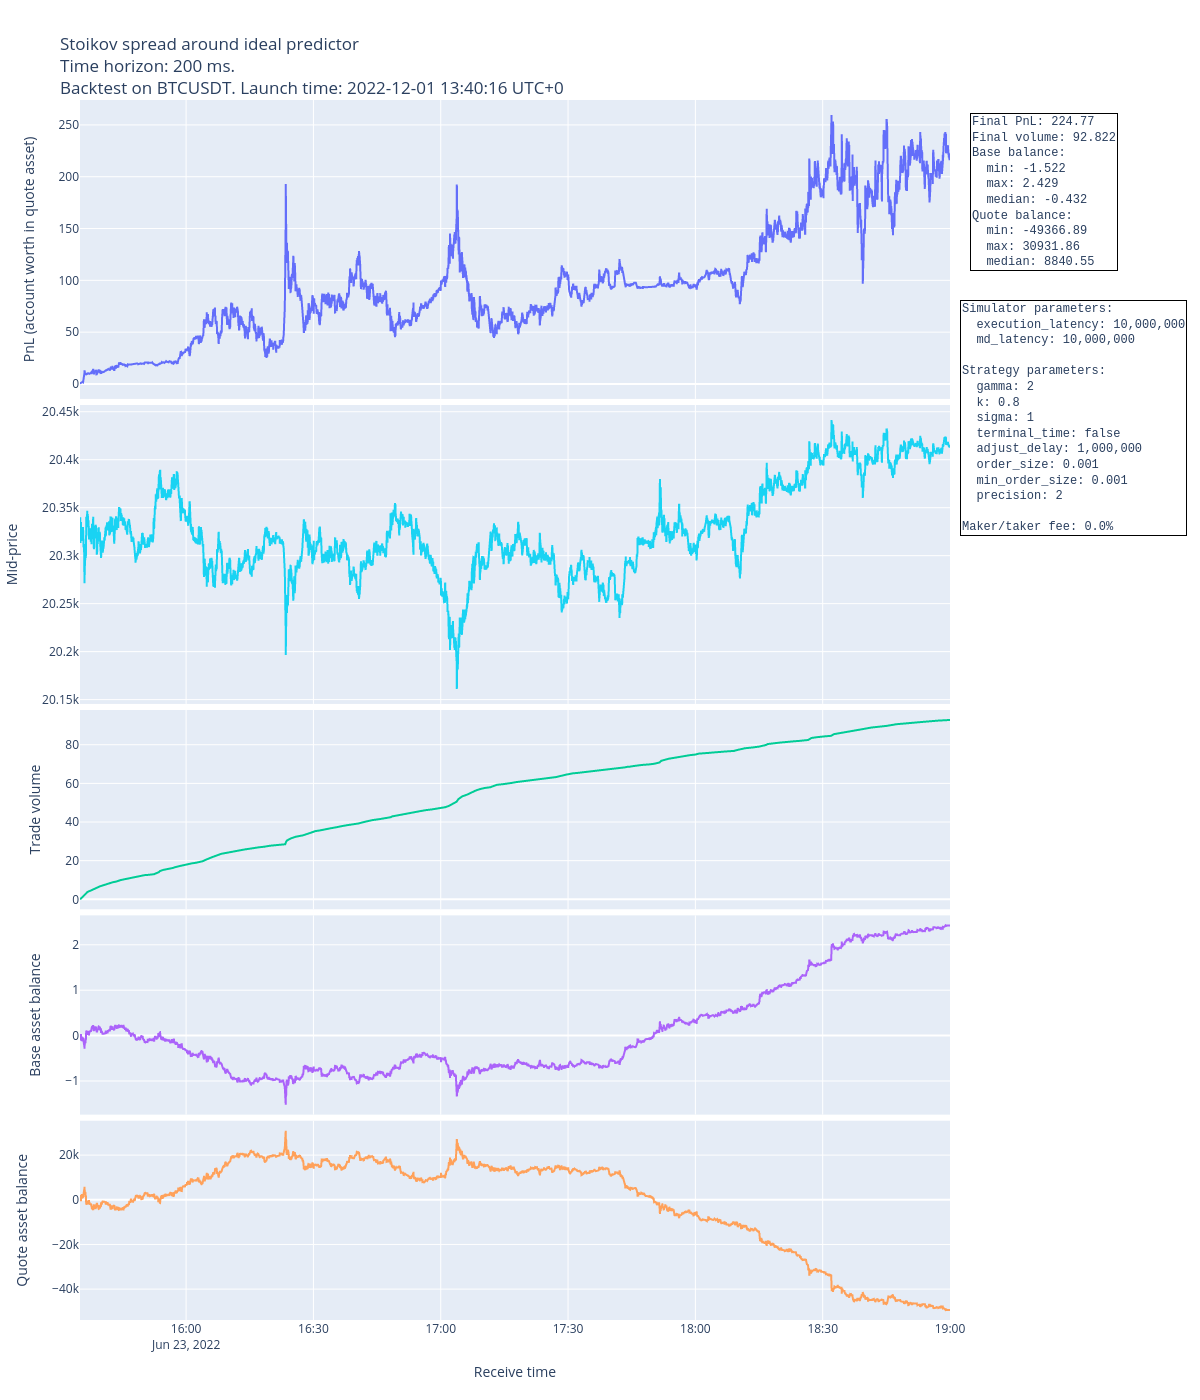

In [27]:
fig = plot_metrics(metrics_ideal[::60],
                   title=f'Stoikov spread around ideal predictor<br>'
                         f'Time horizon: 200 ms.'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_ideal}')
anno_metrics_numeric(fig, metrics_num_ideal)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/04_200_ms_ideal.png')

# Noisy predictors, 200 ms time horizon

## Prediction error: $\pm 0.2\%$

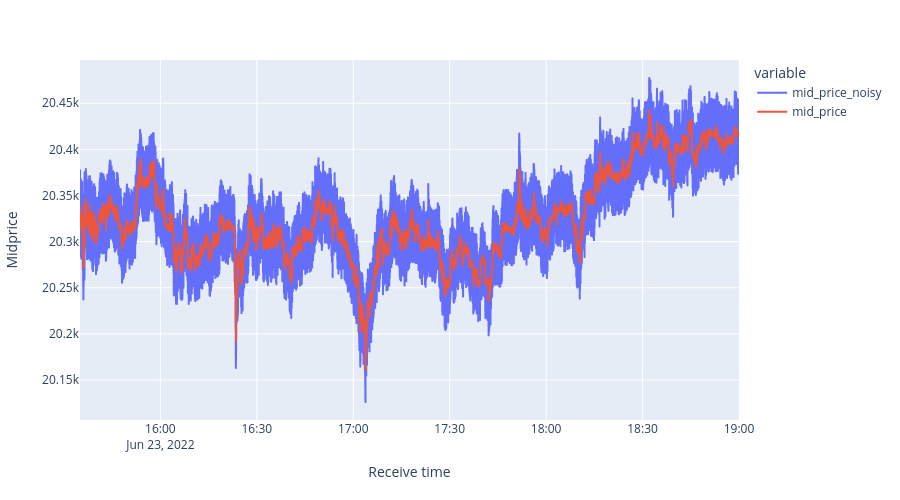

In [28]:
md_df['mid_price_noisy'] = md_df['mid_price']*np.random.uniform(0.998, 1.002, size=len(md_df))
fig = px.line(md_df[::60], x='receive_ts', y=md_df.columns[[-1, -2]])
fig.update_layout(xaxis_title='Receive time', yaxis_title='Midprice', width=900)
fig.show(renderer='png')

In [29]:
predictor_noisy1 = PredictorNoisy(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                  time_offset=pd.Timedelta(200_000_000),
                                  noise_func=lambda: np.random.uniform(0.998, 1.002))

In [ ]:
metrics_noisy1, metrics_num_noisy1 = backtest(md, predictor_noisy1, sim_params, strat_params, FEE)
launch_time_noisy1 = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

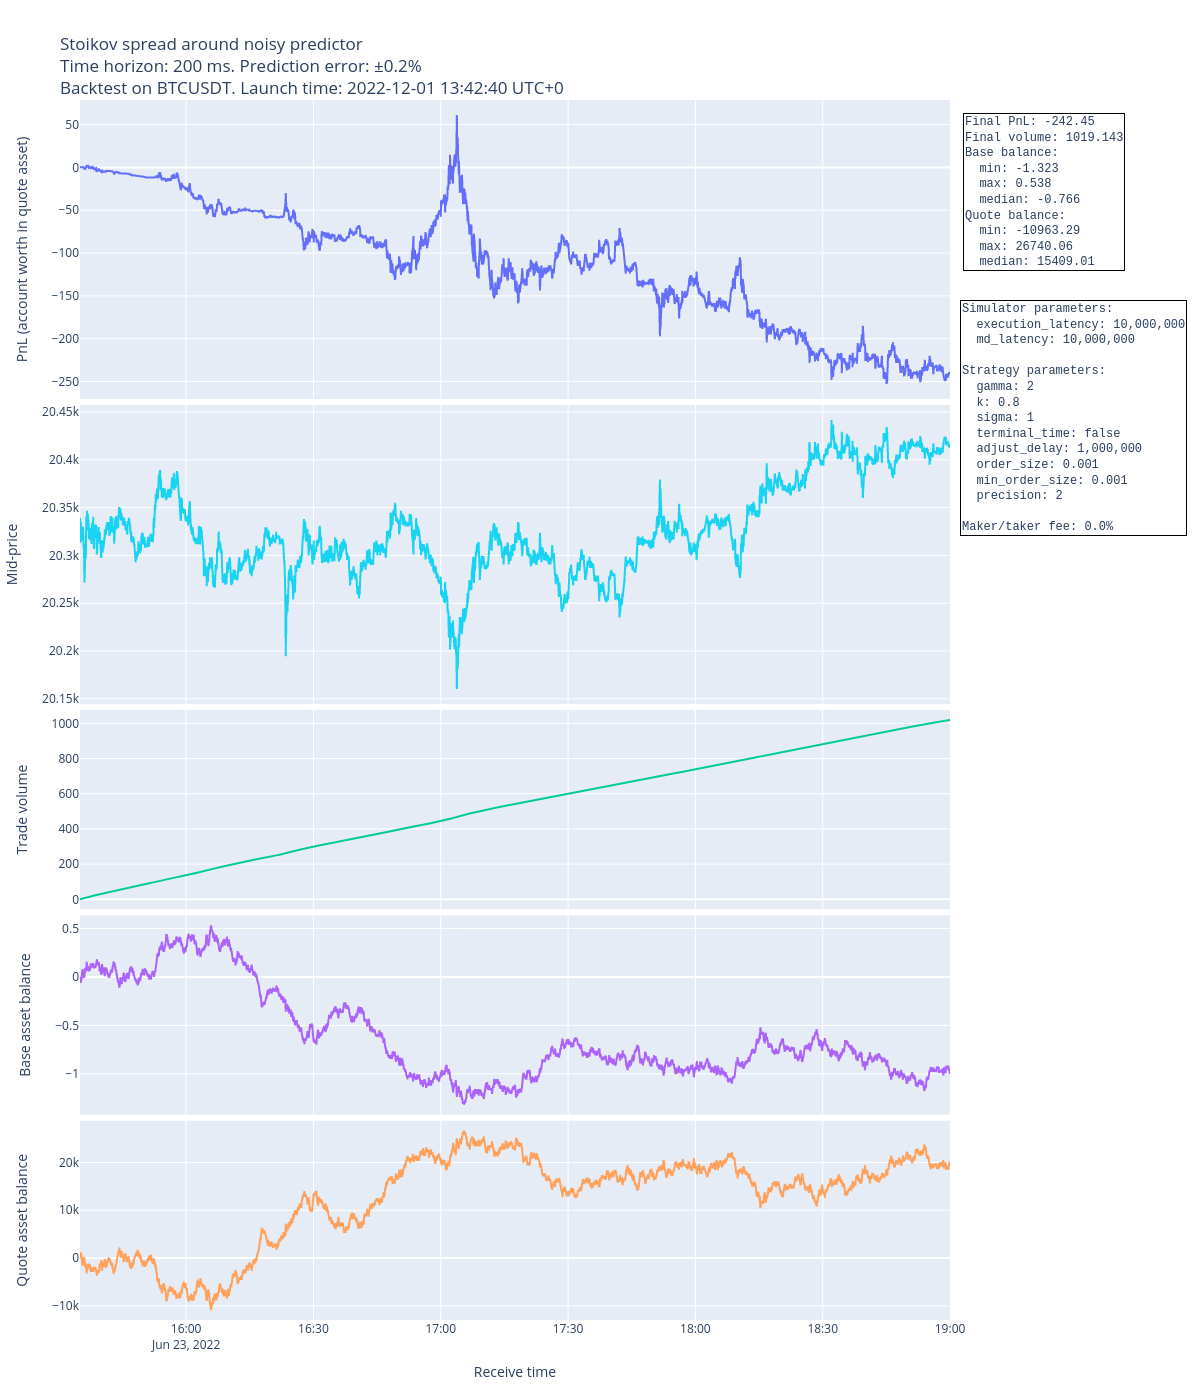

In [31]:
fig = plot_metrics(metrics_noisy1[::60],
                   title=f'Stoikov spread around noisy predictor<br>'
                         f'Time horizon: 200 ms. Prediction error: ±0.2%'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_noisy1}')
anno_metrics_numeric(fig, metrics_num_noisy1)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/05_200_ms_err_0.2%.png')

## Prediction error: $\pm 0.5\%$

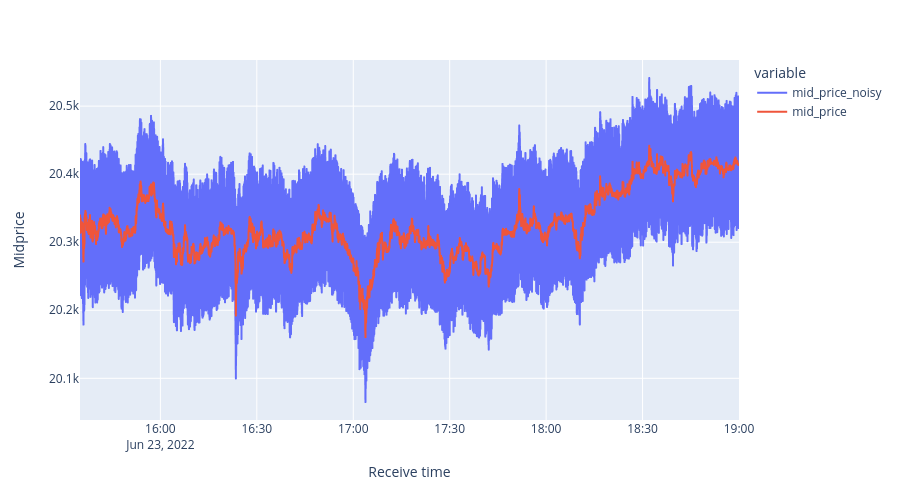

In [32]:
md_df['mid_price_noisy'] = md_df['mid_price']*np.random.uniform(0.995, 1.005, size=len(md_df))
fig = px.line(md_df[::60], x='receive_ts', y=md_df.columns[[-1, -2]])
fig.update_layout(xaxis_title='Receive time', yaxis_title='Midprice', width=900)
fig.show(renderer='png')

In [33]:
predictor_noisy2 = PredictorNoisy(midprices=md_df[['receive_ts', 'mid_price']].set_index('receive_ts'),
                                  time_offset=pd.Timedelta(200_000_000),
                                  noise_func=lambda: np.random.uniform(0.995, 1.005))

In [ ]:
metrics_noisy2, metrics_num_noisy2 = backtest(md, predictor_noisy2, sim_params, strat_params, FEE)
launch_time_noisy2 = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC+0')

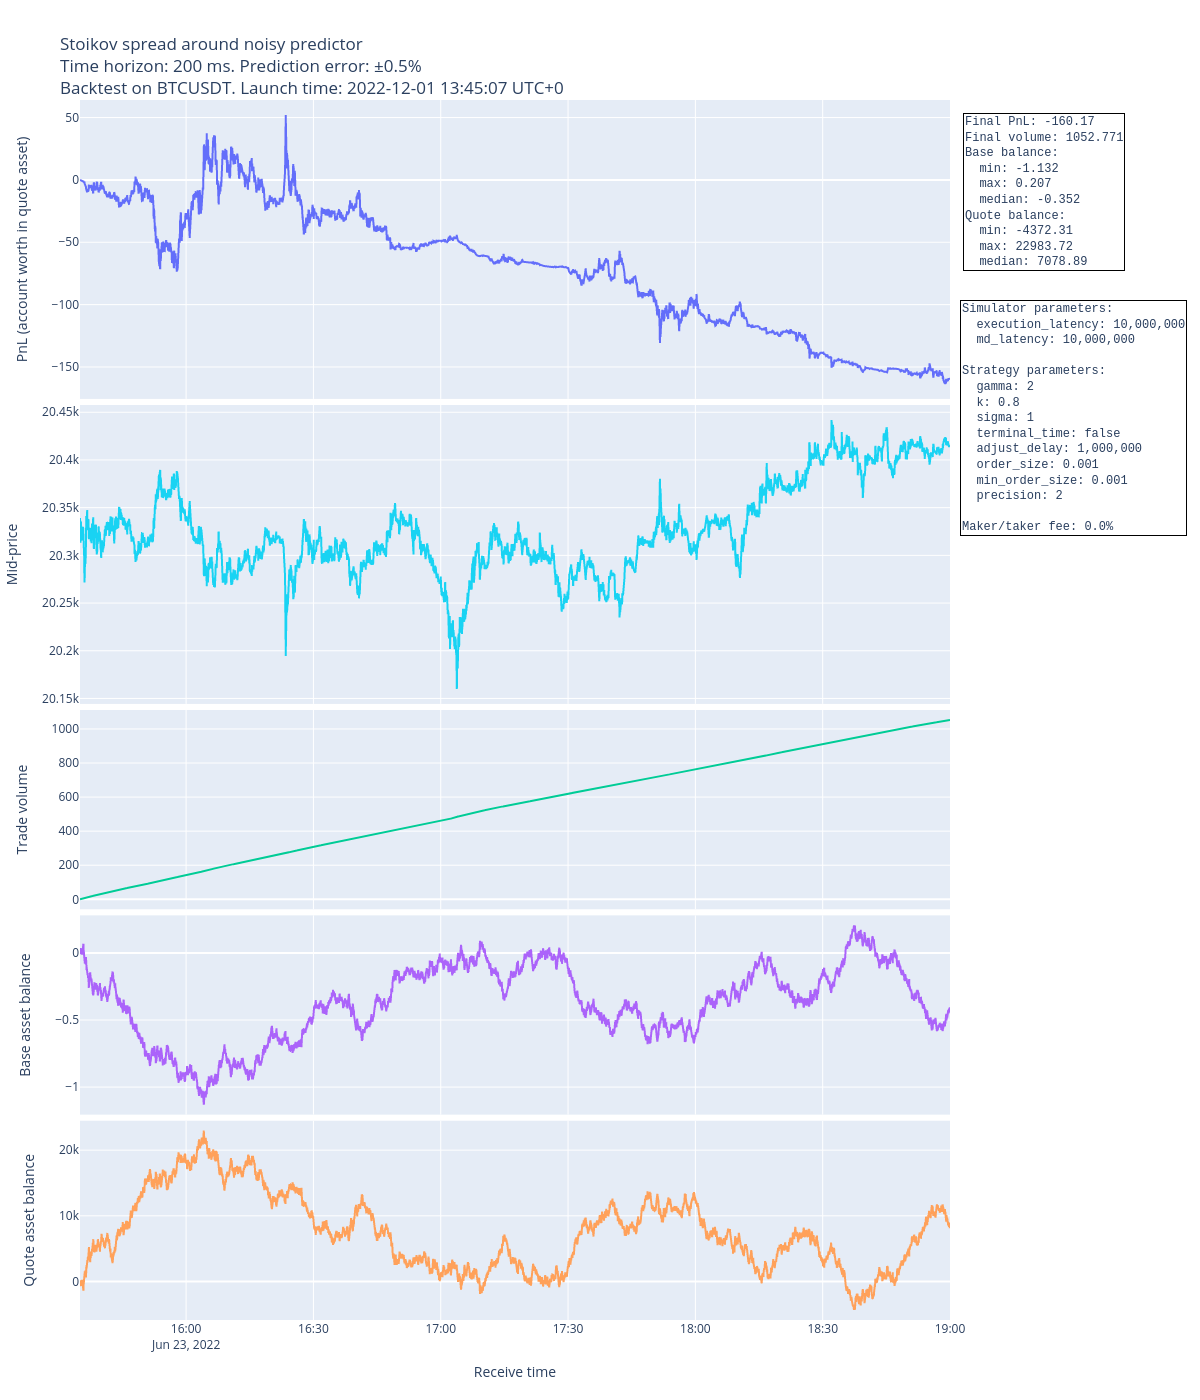

In [35]:
fig = plot_metrics(metrics_noisy2[::60],
                   title=f'Stoikov spread around noisy predictor<br>'
                         f'Time horizon: 200 ms. Prediction error: ±0.5%'
                         f'<br>Backtest on BTCUSDT. Launch time: {launch_time_noisy2}')
anno_metrics_numeric(fig, metrics_num_noisy2)
anno_params(fig, sim_params, strat_params, FEE)
fig.show(renderer='png')
fig.write_image('backtest_results/05_200_ms_err_0.5%.png')

# Comparison

## Stoikov strategy vs Stoikov spread around price predictor

Unlike the Stoikov strategy, PnL of the strategy with ideal predictor (1 second time horizon) is steadily going up, peaking when BTC price makes sharp movements (either up or down), but otherwise seemingly independently of BTC price. When BTC price was going sideways during the period from 15:35 to 18:20, inventory and quote asset balance were oscillating near zero (although, unlike Stoikov strategy, completely erratically and with much bigger amplitude). From 18:20 to 19:30, the price moved up and began to move sideways in the new range. In this period, BTC position was accumulating, and PnL became dependent on BTC price.

This behaviour can be explained as follows. Without loss of generality, suppose that in 1 second the mid-price will be above the current mid-price. We now place bid and ask orders around that future mid-price. If the future mid-price is big enough, our bid order will cross the ask-side of the order book, and will be filled at market price. Our ask order, on the other hand, will be placed in the order book. Now, we readjust our orders every 1 ms, but time horizon of predictor is much bigger, so the ask order is likely to be cancelled before price grows high enough to fill it. For that reason, in order for us to realize the profit, the price will have to go down after the upward movement. Otherwise, we will be accumulating the long position in BTC.

If we look at the trade volume, it is approximately 6 times bigger than for original Stoikov strategy. But, according to mechanics described above, the majority of this volume is probably *due to taker orders, not maker*.

If we decrease time horizon of the predictor to 200 ms, PnL becomes much more volatile, but BTC and quote balance, conversely, become much less volatile. The trade volume decreases. In other aspects, behaviour is the same as for predictor with 1 second time horizon.

## Noisy predictors

If the uniform random noise is added to predictors, PnL no longer steadily goes up. Peaks during the sharp market movements still generally happen, but sometimes not so distinctively. Trade volume is the same for strategies with 1 second noisy predictor and 200 ms noisy predictor, and it's equal to 1000 BTC at the end. It is much higher than for strategies with ideal predictors (3 times higher for 1 second predictor, 10 times higher for 200 ms predictor).

Otherwise, behaviour of PnL, BTC balance and quote balance becomes too random for straightforward analysis. Thus, it may be better to implement real predictor and perform backtesting with it, instead of experimenting with different types of noise.

# Conclusions

Placing bid/ask orders around predicted price in the future is a good idea, because it delivers stable positive PnL, but in order to use this strategy for market making, two problems must be solved:

1. taker volume must be eliminated or greatly decreased;
2. accumulation of long/short position in BTC must be avoided.

This strategy should also be tested with a real predictor implementation.